In [7]:
import pandas as pd
import prince
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
import numpy as np

In [10]:
data = pd.read_csv("df_arabica_final.csv", index_col=0)
data.head()

,Country of Origin,Company,Altitude,Region,Number of Bags,Bag Weight,In-Country Partner,Harvest Year,Owner,Variety,...,Overall,Total Cup Points,Moisture Percentage,Category One Defects,Quakers,Color,Category Two Defects,Certification Body,Shelf_Life_Days,Specialty coffee score grade
0,Colombia,Coffee Quality Union,1815.0,"Piendamo,Cauca",1,35 kg,Japan Coffee Exchange,2021,Coffee Quality Union,Castillo,...,8.58,89.33,11.8,0,0,green,3,Japan Coffee Exchange,365,Excellent
1,Taiwan,Taiwan Coffee Laboratory,1200.0,Chiayi,1,80 kg,Taiwan Coffee Laboratory 台灣咖啡研究室,2021,Taiwan Coffee Laboratory 台灣咖啡研究室,Gesha,...,8.50,87.58,10.5,0,0,blue-green,0,Taiwan Coffee Laboratory 台灣咖啡研究室,365,Excellent
2,Laos,Taiwan Coffee Laboratory,1300.0,Laos Borofen Plateau,19,25 kg,Taiwan Coffee Laboratory 台灣咖啡研究室,2021,Taiwan Coffee Laboratory 台灣咖啡研究室,Java,...,8.33,87.42,10.4,0,0,yellowish,2,Taiwan Coffee Laboratory 台灣咖啡研究室,365,Excellent
3,Costa Rica,Coffee Quality Union,1900.0,"Los Santos,Tarrazu",1,22 kg,Japan Coffee Exchange,2022,Coffee Quality Union,Gesha,...,8.25,87.17,11.8,0,0,green,0,Japan Coffee Exchange,365,Excellent
4,Colombia,Coffee Quality Union,1975.0,"Popayan,Cauca",2,24 kg,Japan Coffee Exchange,2022,Coffee Quality Union,Red Bourbon,...,8.25,87.08,11.6,0,2,yellow-green,2,Japan Coffee Exchange,365,Excellent


In [11]:
# Remove 'kg' in variable Bag Weight and convert to float
data['Bag Weight'] = data['Bag Weight'].str.replace('kg', '', regex=False).str.strip().astype(float)
# Make the Harvest Year a categorical
data['Harvest Year'] = data['Harvest Year'].astype('category')

## Initial Model fitting 

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample
from collections import Counter
import numpy as np
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Define response and predictors
response = 'Specialty coffee score grade'

# Remove minority class (the class with smallest support)
minority_class = data[response].value_counts().idxmin()
data_filtered = data[data[response] != minority_class]

x = data_filtered.drop(columns=[response, 'Total Cup Points'])
y = data_filtered[response]

# Encode categorical features and target
x_encoded = pd.get_dummies(x)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split 80% train, 20% test with stratify
x_train, x_test, y_train, y_test = train_test_split(
    x_encoded, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

n_bootstraps = 100

# Store accuracies
rf_train_accuracies = []
rf_test_accuracies = []
xgb_train_accuracies = []
xgb_test_accuracies = []
svm_train_accuracies = []
svm_test_accuracies = []

all_boot_preds_rf_train, all_boot_preds_rf_test = [], []
all_boot_preds_xgb_train, all_boot_preds_xgb_test = [], []
all_boot_preds_svm_train, all_boot_preds_svm_test = [], []

for b in range(n_bootstraps):
    # Bootstrap sample from training data
    x_bootstrap, y_bootstrap = resample(
        x_train, y_train,
        replace=True,
        stratify=y_train,
        random_state=42 + b
    )

    # Initialize models
    rf = RandomForestClassifier(class_weight='balanced', random_state=42 + b)
    xgb = XGBClassifier(eval_metric='mlogloss', random_state=42 + b)
    svm = SVC(class_weight='balanced', probability=False, random_state=42 + b)

    # Fit models
    rf.fit(x_bootstrap, y_bootstrap)
    xgb.fit(x_bootstrap, y_bootstrap)
    svm.fit(x_bootstrap, y_bootstrap)

    # Predict train and test sets
    all_boot_preds_rf_train.append(rf.predict(x_train))
    all_boot_preds_rf_test.append(rf.predict(x_test))

    all_boot_preds_xgb_train.append(xgb.predict(x_train))
    all_boot_preds_xgb_test.append(xgb.predict(x_test))

    all_boot_preds_svm_train.append(svm.predict(x_train))
    all_boot_preds_svm_test.append(svm.predict(x_test))

def majority_vote(preds_list):
    preds_array = np.array(preds_list)  # shape (n_bootstraps, n_samples)
    final_preds = []
    for col_preds in preds_array.T:
        counts = Counter(col_preds)
        final_preds.append(counts.most_common(1)[0][0])
    return final_preds

# Aggregate predictions with majority vote
rf_train_preds = majority_vote(all_boot_preds_rf_train)
rf_test_preds = majority_vote(all_boot_preds_rf_test)

xgb_train_preds = majority_vote(all_boot_preds_xgb_train)
xgb_test_preds = majority_vote(all_boot_preds_xgb_test)

svm_train_preds = majority_vote(all_boot_preds_svm_train)
svm_test_preds = majority_vote(all_boot_preds_svm_test)

# Compute accuracies
rf_train_acc = accuracy_score(y_train, rf_train_preds)
rf_test_acc = accuracy_score(y_test, rf_test_preds)

xgb_train_acc = accuracy_score(y_train, xgb_train_preds)
xgb_test_acc = accuracy_score(y_test, xgb_test_preds)

svm_train_acc = accuracy_score(y_train, svm_train_preds)
svm_test_acc = accuracy_score(y_test, svm_test_preds)

print("\nRandom Forest Classification Report (Train):")
print(classification_report(y_train, rf_train_preds, target_names=le.classes_))
print("Random Forest Classification Report (Test):")
print(classification_report(y_test, rf_test_preds, target_names=le.classes_))
print(f"Random Forest Train Accuracy: {rf_train_acc:.4f}")
print(f"Random Forest Test Accuracy: {rf_test_acc:.4f}")

print("\nXGBoost Classification Report (Train):")
print(classification_report(y_train, xgb_train_preds, target_names=le.classes_))
print("XGBoost Classification Report (Test):")
print(classification_report(y_test, xgb_test_preds, target_names=le.classes_))
print(f"XGBoost Train Accuracy: {xgb_train_acc:.4f}")
print(f"XGBoost Test Accuracy: {xgb_test_acc:.4f}")

print("\nSVM Classification Report (Train):")
print(classification_report(y_train, svm_train_preds, target_names=le.classes_))
print("SVM Classification Report (Test):")
print(classification_report(y_test, svm_test_preds, target_names=le.classes_))
print(f"SVM Train Accuracy: {svm_train_acc:.4f}")
print(f"SVM Test Accuracy: {svm_test_acc:.4f}")


Random Forest Classification Report (Train):
              precision    recall  f1-score   support

   Excellent       1.00      1.00      1.00        36
   Very Good       1.00      1.00      1.00       116

    accuracy                           1.00       152
   macro avg       1.00      1.00      1.00       152
weighted avg       1.00      1.00      1.00       152

Random Forest Classification Report (Test):
              precision    recall  f1-score   support

   Excellent       0.89      0.89      0.89         9
   Very Good       0.97      0.97      0.97        30

    accuracy                           0.95        39
   macro avg       0.93      0.93      0.93        39
weighted avg       0.95      0.95      0.95        39

Random Forest Train Accuracy: 1.0000
Random Forest Test Accuracy: 0.9487

XGBoost Classification Report (Train):
              precision    recall  f1-score   support

   Excellent       1.00      1.00      1.00        36
   Very Good       1.00      1.00 

## Feature Selection

Optimal number of features: 8
Selected features:
['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 'Overall', 'Moisture Percentage']


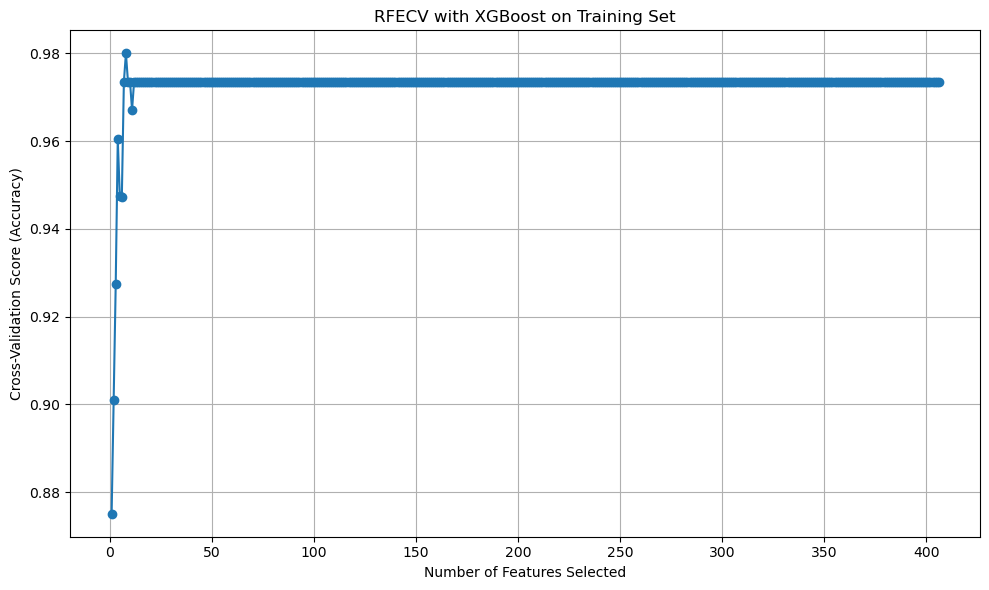

<Figure size 1000x600 with 0 Axes>

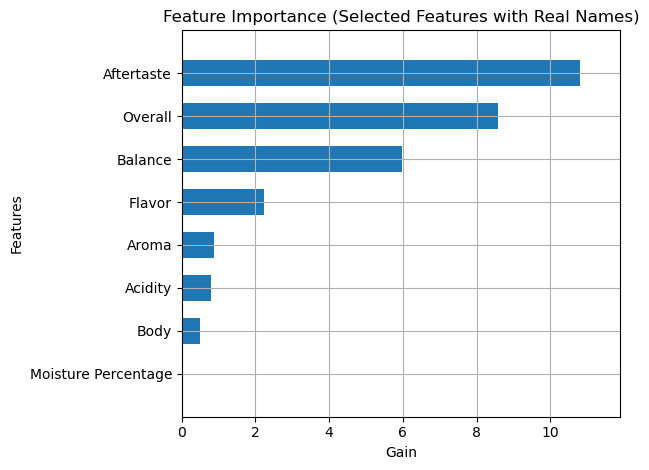

In [15]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import LabelEncoder
from xgboost import plot_importance
import matplotlib.pyplot as plt
import pandas as pd


# Define model
xgb = XGBClassifier(
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=-1
)

# SRFECV with stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rfecv = RFECV(
    estimator=xgb,
    step=1,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

rfecv.fit(x_train, y_train)

# Output selected features
selected_features = x_train.columns[rfecv.support_]
print("Optimal number of features:", rfecv.n_features_)
print("Selected features:")
print(selected_features.tolist())

# Plot RFECV cross-validation score
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
         rfecv.cv_results_['mean_test_score'], marker='o')
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross-Validation Score (Accuracy)")
plt.title("RFECV with XGBoost on Training Set")
plt.grid(True)
plt.tight_layout()
plt.show()

xgb_selected = XGBClassifier(
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=-1
)
xgb_selected.fit(x_train[selected_features], y_train)

# Step 8: Plot feature importance with real names
plt.figure(figsize=(10, 6))
plot_importance(
    xgb_selected,
    importance_type='gain',
    xlabel='Gain',
    show_values=False,
    height=0.6,
    grid=True
)
plt.title("Feature Importance (Selected Features with Real Names)")
plt.tight_layout()
plt.show()

In [16]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample
from collections import Counter
import numpy as np

# Subset train and test data using selected features
x_train_selected = x_train[selected_features]
x_test_selected = x_test[selected_features]

n_bootstraps = 100

# Store predictions for majority voting
all_boot_preds_xgb_train = []
all_boot_preds_xgb_test = []

for b in range(n_bootstraps):
    # Bootstrap sample from training data (with selected features)
    x_bootstrap, y_bootstrap = resample(
        x_train_selected, y_train,
        replace=True,
        stratify=y_train,
        random_state=42 + b
    )

    # Initialize XGBoost model
    xgb = XGBClassifier(
        eval_metric='mlogloss',
        random_state=42 + b,
        n_jobs=-1
    )

    # Fit model on bootstrap sample
    xgb.fit(x_bootstrap, y_bootstrap)

    # Predict on entire train and test sets (selected features only)
    all_boot_preds_xgb_train.append(xgb.predict(x_train_selected))
    all_boot_preds_xgb_test.append(xgb.predict(x_test_selected))

def majority_vote(preds_list):
    preds_array = np.array(preds_list)  # shape (n_bootstraps, n_samples)
    final_preds = []
    for col_preds in preds_array.T:
        counts = Counter(col_preds)
        final_preds.append(counts.most_common(1)[0][0])
    return final_preds

# Aggregate predictions with majority vote
xgb_train_preds = majority_vote(all_boot_preds_xgb_train)
xgb_test_preds = majority_vote(all_boot_preds_xgb_test)

# Calculate accuracies
xgb_train_acc = accuracy_score(y_train, xgb_train_preds)
xgb_test_acc = accuracy_score(y_test, xgb_test_preds)

print("\nXGBoost Classification Report (Train):")
print(classification_report(y_train, xgb_train_preds, target_names=le.classes_))
print("XGBoost Classification Report (Test):")
print(classification_report(y_test, xgb_test_preds, target_names=le.classes_))
print(f"XGBoost Train Accuracy: {xgb_train_acc:.4f}")
print(f"XGBoost Test Accuracy: {xgb_test_acc:.4f}")


XGBoost Classification Report (Train):
              precision    recall  f1-score   support

   Excellent       1.00      1.00      1.00        36
   Very Good       1.00      1.00      1.00       116

    accuracy                           1.00       152
   macro avg       1.00      1.00      1.00       152
weighted avg       1.00      1.00      1.00       152

XGBoost Classification Report (Test):
              precision    recall  f1-score   support

   Excellent       0.82      1.00      0.90         9
   Very Good       1.00      0.93      0.97        30

    accuracy                           0.95        39
   macro avg       0.91      0.97      0.93        39
weighted avg       0.96      0.95      0.95        39

XGBoost Train Accuracy: 1.0000
XGBoost Test Accuracy: 0.9487


## Hyperparameter tuning

In [18]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import resample
from collections import Counter
import numpy as np
from xgboost import XGBClassifier
import pandas as pd

# Define param grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

n_bootstraps = 30  # Can reduce to save time

all_best_estimators = []
all_boot_preds_train = []
all_boot_preds_test = []

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for b in range(n_bootstraps):
    print(f"Bootstrap {b+1}/{n_bootstraps}")
    
    # Bootstrap resampling
    x_bootstrap, y_bootstrap = resample(
        x_train_selected, y_train,
        replace=True,
        stratify=y_train,
        random_state=42 + b
    )

    # Base XGBoost model
    xgb = XGBClassifier(
        eval_metric='mlogloss',
        random_state=42 + b,
        n_jobs=-1
    )

    # Grid search with CV
    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        scoring='accuracy',
        cv=cv,
        n_jobs=-1,
        verbose=0
    )

    grid_search.fit(x_bootstrap, y_bootstrap)

    # Save best estimator
    best_model = grid_search.best_estimator_
    all_best_estimators.append(best_model)

    # Predict on full train and test sets
    all_boot_preds_train.append(best_model.predict(x_train_selected))
    all_boot_preds_test.append(best_model.predict(x_test_selected))

# Majority vote function
def majority_vote(preds_list):
    preds_array = np.array(preds_list)  # shape (n_bootstraps, n_samples)
    final_preds = []
    for col_preds in preds_array.T:
        counts = Counter(col_preds)
        final_preds.append(counts.most_common(1)[0][0])
    return final_preds

# Final predictions by majority vote
train_preds = majority_vote(all_boot_preds_train)
test_preds = majority_vote(all_boot_preds_test)

# Evaluate performance
train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)

print("\nXGBoost Classification Report (Train):")
print(classification_report(y_train, train_preds, target_names=le.classes_))
print("XGBoost Classification Report (Test):")
print(classification_report(y_test, test_preds, target_names=le.classes_))
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Extract and summarize best parameters across bootstraps
param_keys = param_grid.keys()
best_params_list = [est.get_params() for est in all_best_estimators]
best_params_filtered = [
    tuple((param, params[param]) for param in param_keys)
    for params in best_params_list
]

# Count most frequent parameter set
param_counts = Counter(best_params_filtered)
most_common_params, count = param_counts.most_common(1)[0]
best_overall_params = dict(most_common_params)

print("\nMost Commonly Selected Hyperparameters Across Bootstraps:")
for k, v in best_overall_params.items():
    print(f"{k}: {v}")
print(f"Selected in {count} out of {n_bootstraps} bootstraps.")

Bootstrap 1/30
Bootstrap 2/30
Bootstrap 3/30
Bootstrap 4/30
Bootstrap 5/30
Bootstrap 6/30
Bootstrap 7/30
Bootstrap 8/30
Bootstrap 9/30
Bootstrap 10/30
Bootstrap 11/30
Bootstrap 12/30
Bootstrap 13/30
Bootstrap 14/30
Bootstrap 15/30
Bootstrap 16/30
Bootstrap 17/30
Bootstrap 18/30
Bootstrap 19/30
Bootstrap 20/30
Bootstrap 21/30
Bootstrap 22/30
Bootstrap 23/30
Bootstrap 24/30
Bootstrap 25/30
Bootstrap 26/30
Bootstrap 27/30
Bootstrap 28/30
Bootstrap 29/30
Bootstrap 30/30

XGBoost Classification Report (Train):
              precision    recall  f1-score   support

   Excellent       1.00      1.00      1.00        36
   Very Good       1.00      1.00      1.00       116

    accuracy                           1.00       152
   macro avg       1.00      1.00      1.00       152
weighted avg       1.00      1.00      1.00       152

XGBoost Classification Report (Test):
              precision    recall  f1-score   support

   Excellent       0.90      1.00      0.95         9
   Very Good   

## PDP

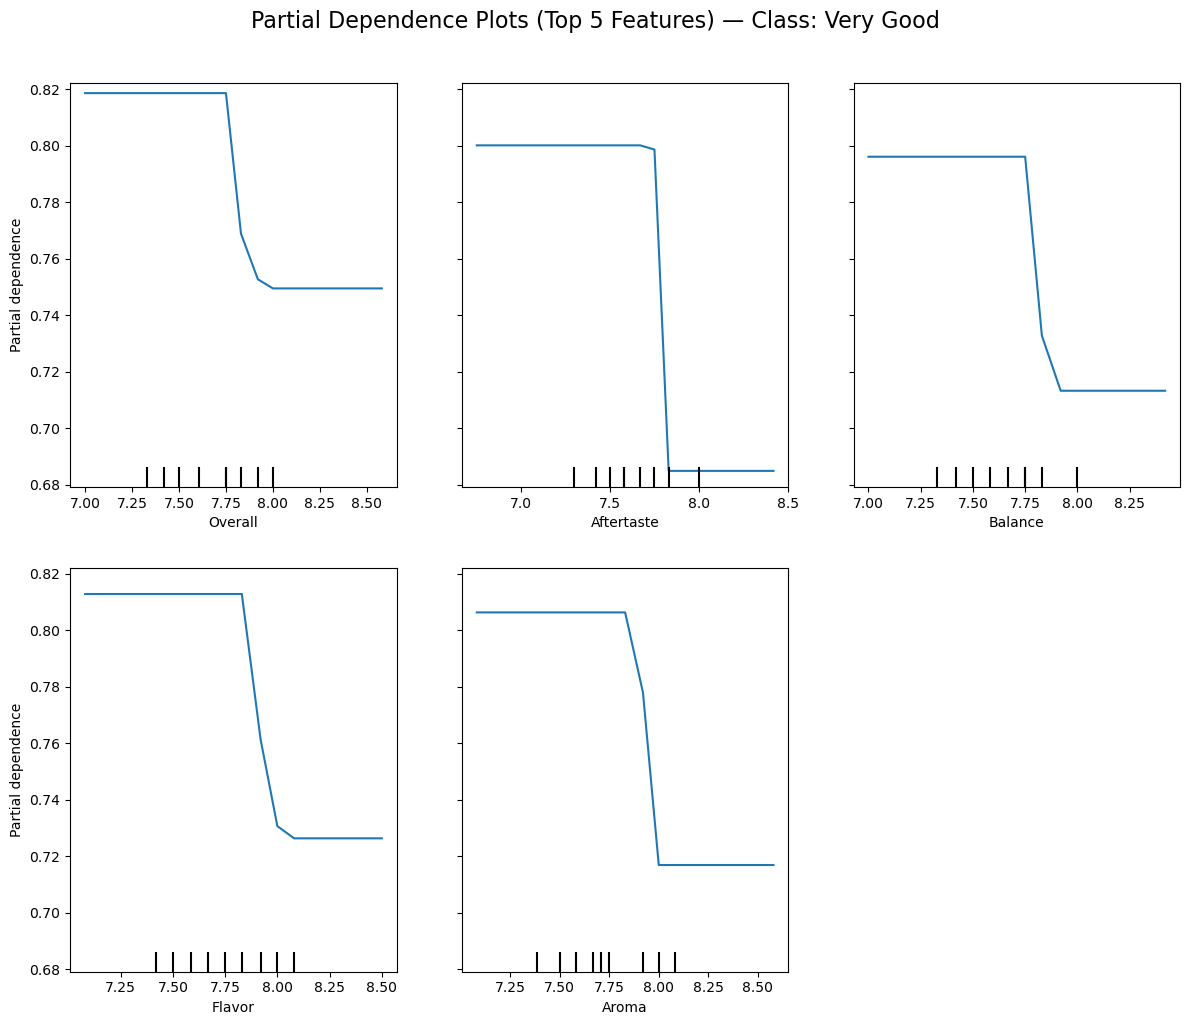

In [20]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Fit final model with best hyperparameters
final_model = XGBClassifier(
    n_estimators=50,
    max_depth=3,
    learning_rate=0.1,
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=-1,
    subsample=0.8,
    colsample_bytree=0.8
)
final_model.fit(x_train_selected, y_train)

# Get top 5 features by gain
importance_df = pd.DataFrame({
    'feature': selected_features,
    'importance': final_model.feature_importances_
}).sort_values(by='importance', ascending=False)

top5_features = importance_df['feature'].head(5).tolist()

# Pick a target class to plot (e.g., class index 0 or class name from LabelEncoder)
target_class_idx = 1  # "Very Good" class in the response

# Plot PDPs for top 5 features for one class
fig, ax = plt.subplots(figsize=(12, 10))
PartialDependenceDisplay.from_estimator(
    final_model,
    X=x_train_selected,
    features=top5_features,
    kind='average',
    target=target_class_idx,
    grid_resolution=100,
    ax=ax
)
plt.suptitle(f"Partial Dependence Plots (Top 5 Features) — Class: {le.classes_[target_class_idx]}", fontsize=16, y=1.02)
plt.tight_layout()

# Save the figure
plt.savefig("pdp_top5_features_class_VeryGood.png", dpi=300)

plt.show()

Final XGBoost Classification Report (Train):
              precision    recall  f1-score   support

   Excellent       1.00      1.00      1.00        36
   Very Good       1.00      1.00      1.00       116

    accuracy                           1.00       152
   macro avg       1.00      1.00      1.00       152
weighted avg       1.00      1.00      1.00       152


Final XGBoost Classification Report (Test):
              precision    recall  f1-score   support

   Excellent       0.90      1.00      0.95         9
   Very Good       1.00      0.97      0.98        30

    accuracy                           0.97        39
   macro avg       0.95      0.98      0.97        39
weighted avg       0.98      0.97      0.97        39



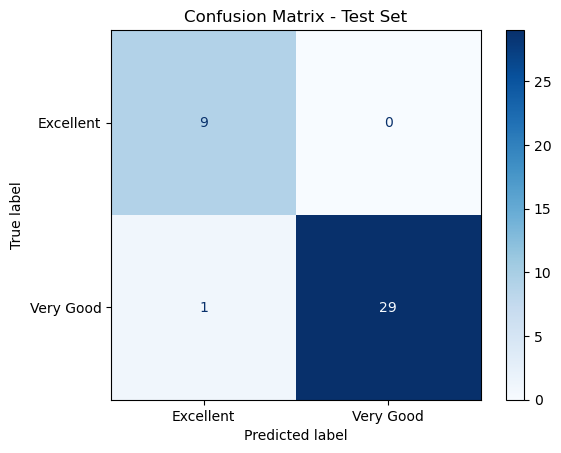

<Figure size 1000x600 with 0 Axes>

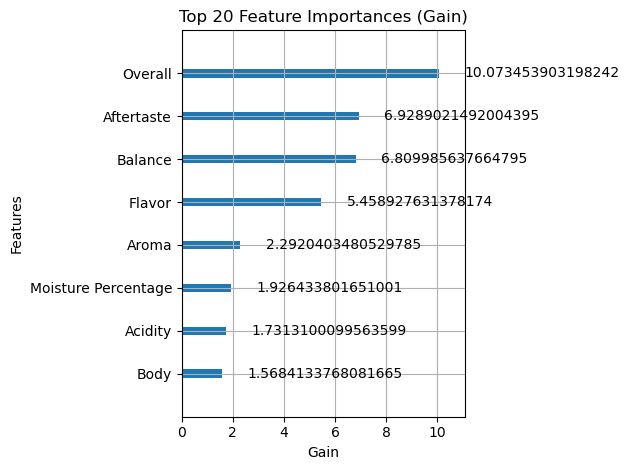

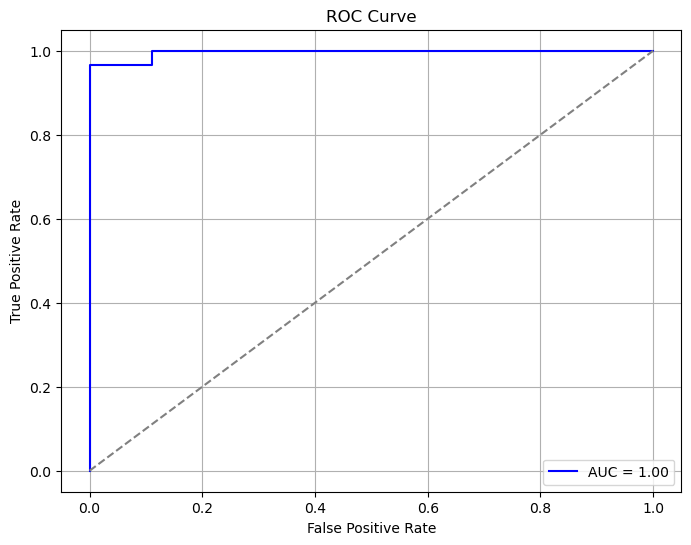

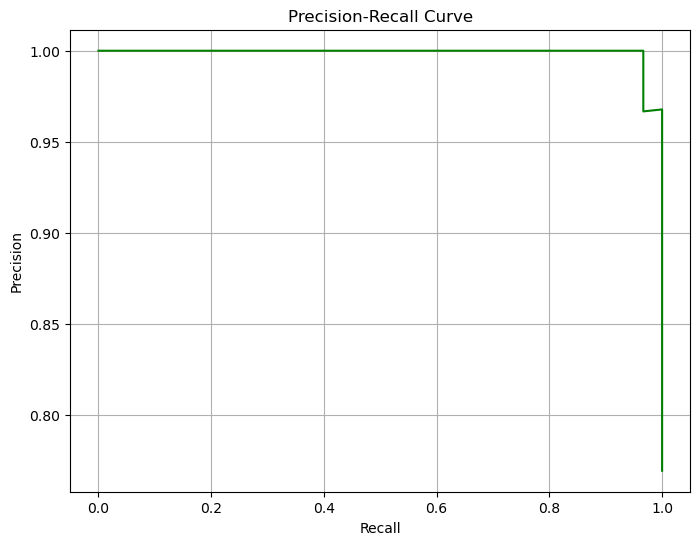


Top 5 features for PDP: ['Overall', 'Aftertaste', 'Balance', 'Flavor', 'Aroma']


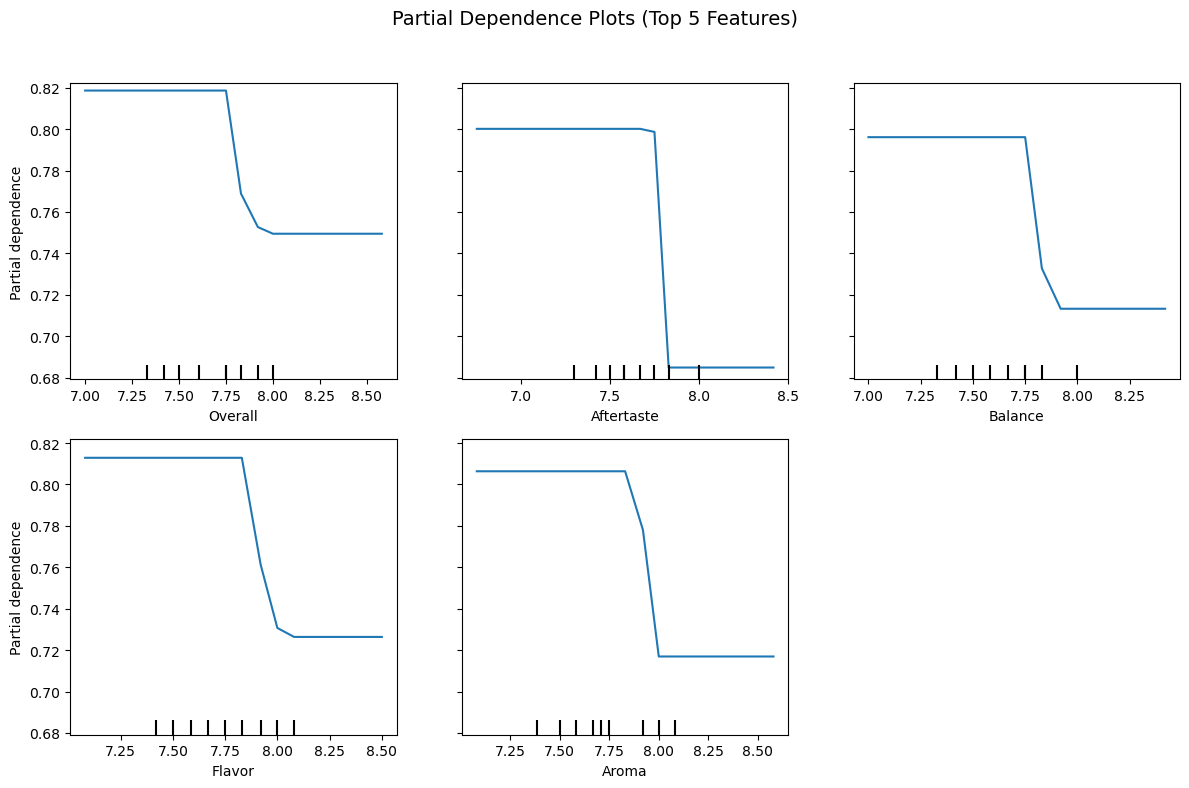

In [21]:
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    precision_recall_curve
)
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import numpy as np

# ============================
# Train final XGBoost model
# ============================
best_model = XGBClassifier(
    n_estimators=50,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mlogloss',
    random_state=42
)

best_model.fit(x_train_selected, y_train)

# Predictions
y_train_pred = best_model.predict(x_train_selected)
y_test_pred = best_model.predict(x_test_selected)

# Classification Reports
print("Final XGBoost Classification Report (Train):")
print(classification_report(y_train, y_train_pred, target_names=le.classes_))
print("\nFinal XGBoost Classification Report (Test):")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

# ============================
# Confusion Matrix
# ============================
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.savefig("confusion_matrix_test.png", dpi=300, bbox_inches='tight')
plt.show()

# ============================
# Feature Importance (Gain)
# ============================
plt.figure(figsize=(10, 6))
plot_importance(best_model, max_num_features=20, importance_type='gain', xlabel='Gain')
plt.title("Top 20 Feature Importances (Gain)")
plt.tight_layout()
plt.savefig("feature_importance_gain.png", dpi=300, bbox_inches='tight')
plt.show()

# ============================
# ROC Curve (Binary Classification Only)
# ============================
if len(le.classes_) == 2:  # Only for binary classification
    y_test_prob = best_model.predict_proba(x_test_selected)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig("roc_curve.png", dpi=300, bbox_inches='tight')
    plt.show()

    # ============================
    # Precision-Recall Curve
    # ============================
    precision, recall, _ = precision_recall_curve(y_test, y_test_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='green')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.grid(True)
    plt.savefig("precision_recall_curve.png", dpi=300, bbox_inches='tight')
    plt.show()

# ============================
# Partial Dependence Plots (Top 5 Features)
# ============================
importances = best_model.feature_importances_
top_features = np.argsort(importances)[-5:][::-1]  # Top 5 feature indices
top_feature_names = x_train_selected.columns[top_features]

print("\nTop 5 features for PDP:", top_feature_names.tolist())

fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(
    best_model,
    x_train_selected,
    features=top_features,
    feature_names=x_train_selected.columns,
    grid_resolution=50,
    ax=ax
)
plt.suptitle("Partial Dependence Plots (Top 5 Features)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [22]:
!pip install shap

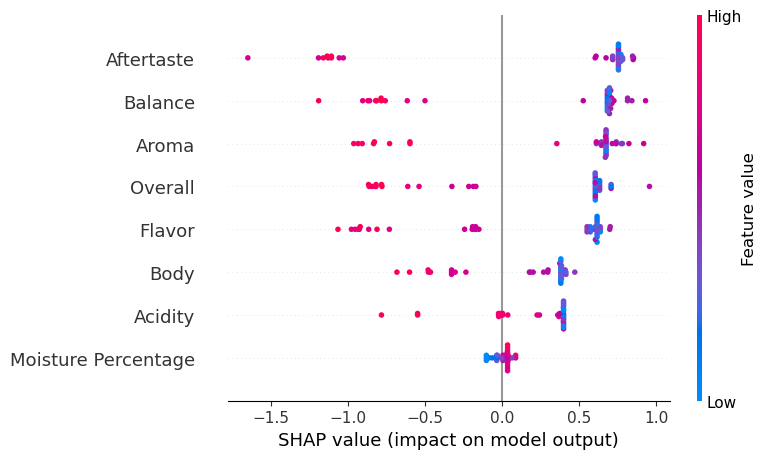

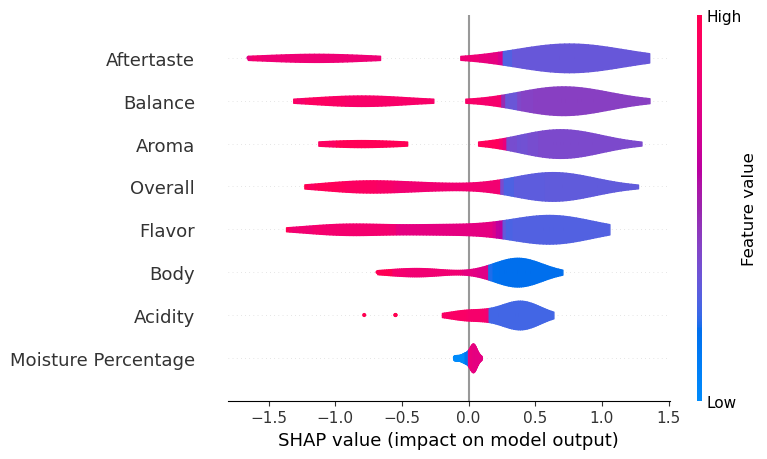

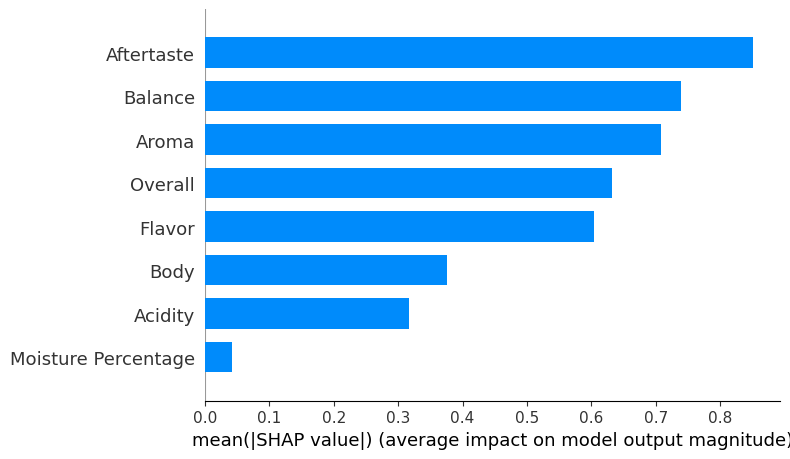

<Figure size 640x480 with 0 Axes>

In [44]:
import shap
import matplotlib.pyplot as plt

# Initialize SHAP explainer for XGBoost
explainer = shap.TreeExplainer(best_model)

# Compute SHAP values on the test set
shap_values = explainer.shap_values(x_test_selected)

# --- SHAP Summary Plot (Beeswarm) ---
shap.summary_plot(shap_values, x_test_selected, show=False)
fig = plt.gcf()
fig.savefig("shap_summary_plot.png", bbox_inches='tight', dpi=300)
plt.show()
plt.clf()

# --- SHAP Beeswarm (Violin Style) ---
shap.summary_plot(shap_values, x_test_selected, plot_type="violin", show=False)
fig = plt.gcf()
fig.savefig("shap_beeswarm_violin.png", bbox_inches='tight', dpi=300)
plt.show()
plt.clf()

# --- SHAP Bar Plot (Mean Absolute SHAP Values) ---
shap.summary_plot(shap_values, x_test_selected, plot_type="bar", show=False)
fig = plt.gcf()
fig.savefig("shap_bar_plot.png", bbox_inches='tight', dpi=300)
plt.show()
plt.clf()